# Zhang 2023 Upper Bound Temperature
This looks at applying the theory from Byrne 2023 but to an aquaplanet.

Looks at how the hottest days compare to the theoretical upper bound temperature for a given the 500hPa temperature.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore
from scipy import interpolate

2023-04-26 15:55:20,455 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'height', 'precipitation', 'cape', 'bucket_depth', 'cin']
tau_lw_ref = 1
tau_lw_warm = 1.2
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

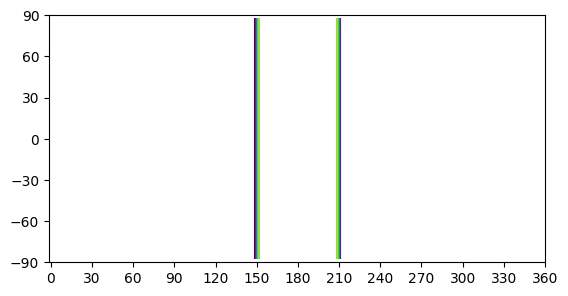

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [4]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2
pressure_ft = 500

ds_all = ds[0].sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
ds_all = ds_all.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True).load()
z_ft_mean = float(area_weighting(ds_all.height[:, 0]).mean())
temp_ft_mean = float(area_weighting(ds_all.temp[:, 0]).mean())
pressure_ft_actual = float(ds_all.pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds_all.pfull[1])          # surface pressure in hPa

In [5]:
temp_bins = np.linspace(ds_all.temp[:, 0].min(), ds_all.temp[:, 0].max(), 20)
z_bins = np.linspace(ds_all.height[:, 0].min(), ds_all.height[:, 0].max(), 20)
hist = np.histogram2d(ds_all.temp[:, 0].to_numpy().flatten(), ds_all.height[:, 0].to_numpy().flatten(), bins=[temp_bins, z_bins])[0]

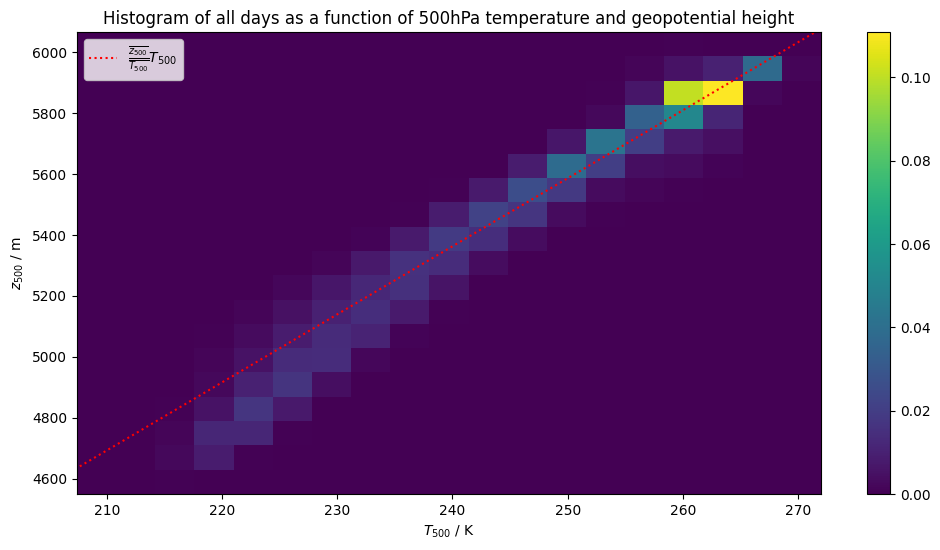

In [6]:
# Check that z_ft vs temp_ft relationship is approximately valid
temp_ft_array = np.arange(200, 300)
fig, ax = plt.subplots(1,1, figsize=(12, 6))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto', extent=[temp_bins[0], temp_bins[-1], z_bins[0], z_bins[-1]])
fig.colorbar(im)
ax.plot(temp_ft_array, (z_ft_mean/temp_ft_mean * temp_ft_array), color='r', linestyle=':',
        label='$\\frac{\overline{z_{500}}}{\overline{T_{500}}} T_{500}$')
ax.set_ylabel(f"$z_{'{'+str(pressure_ft)+'}'}$ / m")
ax.set_xlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
ax.set_title(f'Histogram of all days as a function of {pressure_ft}hPa temperature and geopotential height')
ax.legend()
ax.set_xlim(temp_bins[0], temp_bins[-1])
ax.set_ylim(z_bins[0], z_bins[-1]);

## Figures 3B, 3C
The vorticity used is manually computed, rather than using that outputted from Isca, so may not be particularly useful.

In [7]:
# Choose surface - only plot land or only plot ocean
surf_use = 'land'
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
ds_use = ds_all.sel(lon=np.unique(lon[surf_use]), method='nearest')

In [8]:
# Compute free troposphere vorticity at each time, lon and lat
cos_lat = np.cos(np.deg2rad(ds_use.lat)).to_numpy().reshape(1, -1, 1)
np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2)
np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)
vorticity = (np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2) -
             np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)) / (radius_earth * cos_lat)
vorticity = xr.DataArray(vorticity, coords=ds_use.temp[:,0].coords)

In [9]:
# Compute theoretical upper bound on temperature if completely dry surface
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1 + w_sat)
    return q_sat

temp_upper_bound = temp_ft_array + L_v/c_p * sphum_sat(temp_ft_array, pressure_ft_actual * 100) + \
                   g/c_p * z_ft_mean/temp_ft_mean * temp_ft_array

In [10]:
quant_plot = 90                 # show top 10 percentile temp in plots
lat_min = [0, 40, 70]
lat_max = [20, 65, 90]
n_lat = len(lat_min)
ds_lat = []
vorticity_lat = []
rh_surf_mean = np.zeros(n_lat)      # mean relative humidity in each latitude region (%)
quant_thresh = np.zeros(n_lat)
with tqdm(total=n_lat, position=0, leave=True) as pbar:
    for i in range(n_lat):
        ds_use2 = ds_use.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)
        ds_use2 = ds_use2[['temp', 'sphum', 'height']]      # Only keep min required variables
        vorticity2 = vorticity.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)

        rh_surf_mean[i] = area_weighting(ds_use2.sphum[:, -1]/sphum_sat(ds_use2.temp[:, -1], pressure_surface * 100)).mean() * 100

        quant_thresh[i] = ds_use2.temp[:, -1].quantile(quant_plot/100, dim=['time', 'lat', 'lon'])
        keep = ds_use2.temp[:, -1] > quant_thresh[i]
        vorticity2 = vorticity2.where(keep, drop=True)
        # vorticity2 = vorticity2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        vorticity_lat += [vorticity2]

        keep = np.expand_dims(keep, 1).repeat(ds_use2.temp.shape[1], axis=1)        # repeat keep for both pressure levels
        keep = xr.DataArray(keep, coords=ds_use2.coords)                           # Make it a data array
        ds_use2 = ds_use2.where(keep, drop=True)
        # Collapse lat, lon and time axis and get rid of any nan values corresponding to surface temp below quant_plot percentile
        # ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        # ds_use2 = ds_use2.sel(lon_lat_time = ds_use2.lon_lat_time[np.invert(np.isnan(ds_use2.temp[-1]))].to_numpy())
        ds_lat += [ds_use2]
        pbar.update(1)

100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


In [11]:
# # This cell takes a long time to run!!
# vorticity_max = 0.8 * np.max([np.abs(vorticity_lat[i]).max() for i in range(n_lat)])        # so vorticity on same scale on all plots
# fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
# for i in range(n_lat):
#     im = ax[0, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
#                           c=ds_lat[i].sphum[:, -1]/sphum_sat(ds_lat[i].temp[:, -1], pressure_surface * 100))
#     plt.colorbar(im, ax=ax[0, i], label='Surface Relative Humidity')
#     im = ax[1, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
#                           c=vorticity_lat[i] * np.sign(vorticity_lat[i].lat), cmap='bwr', vmin=-vorticity_max, vmax=vorticity_max)
#     plt.colorbar(im, ax=ax[1, i], label=f'{pressure_ft}hPa Vorticity')
#     ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
#     for k in range(2):
#         # Plot upper bound and upper bound taking account of min surface sphum
#         ax[k, i].plot(temp_ft_array, temp_upper_bound, color='k', linestyle='--')
#         ax[k, i].plot(temp_ft_array, temp_upper_bound - float(L_v/c_p * ds_lat[i].sphum[:, -1].min()), color='k', linestyle=':')
# fig.supxlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
# fig.supylabel('$T_s + \\frac{g}{c_p}z_s$ ($K$)')
# ax[0, 0].set_xlim(np.min([ds_lat[i].temp[:, 0].min() for i in range(n_lat)])-1,
#                   np.max([ds_lat[i].temp[:, 0].max() for i in range(n_lat)])+1)
# ax[0, 0].set_ylim(quant_thresh.min()-1, 310)
# plt.tight_layout()

Below I repeat the above plot but by taking the running average rather than plotting each individual point. This is quicker to run and makes the trends clearer.

In [12]:
n_ft_bins = 30
n_surf_bins = 30
min_data = 10       # only record data if more than this number in the given bin
temp_ft_hist_array = np.linspace(np.min([ds_lat[i].temp[:, 0].min() for i in range(n_lat)])-0.001,
                                 np.max([ds_lat[i].temp[:, 0].max() for i in range(n_lat)])+0.001, n_ft_bins)
temp_surf_hist_array = np.linspace(np.min([ds_lat[i].temp[:, -1].min() for i in range(n_lat)])-0.001,
                                  np.max([ds_lat[i].temp[:, -1].max() for i in range(n_lat)])+0.001, n_surf_bins)
rh_running_mean = np.full((n_lat, n_ft_bins-1, n_surf_bins-1), np.nan)
vorticity_running_mean = np.full((n_lat, n_ft_bins-1, n_surf_bins-1), np.nan)
with tqdm(total= n_lat * (n_ft_bins-1) * (n_surf_bins-1), position=0, leave=True) as pbar:
    for k in range(n_lat):
        rh = ds_lat[k].sphum[:, -1]/sphum_sat(ds_lat[k].temp[:, -1], pressure_surface * 100)
        for i in range(n_ft_bins-1):
            for j in range(n_surf_bins-1):
                keep_ft = np.logical_and(temp_ft_hist_array[i+1] > ds_lat[k].temp[:, 0],
                                         ds_lat[k].temp[:, 0] >= temp_ft_hist_array[i])
                keep_surf = np.logical_and(temp_surf_hist_array[j+1] > ds_lat[k].temp[:, -1],
                                           ds_lat[k].temp[:, -1] >= temp_surf_hist_array[j])
                keep = np.logical_and(keep_ft, keep_surf)
                if np.sum(keep) > min_data:
                    rh_running_mean[k, i, j] = rh.where(keep).mean()
                    vorticity_running_mean[k, i, j] = (vorticity_lat[k] * np.sign(vorticity_lat[k].lat)).where(keep).mean()
                pbar.update(1)

100%|██████████| 2523/2523 [00:14<00:00, 173.47it/s]


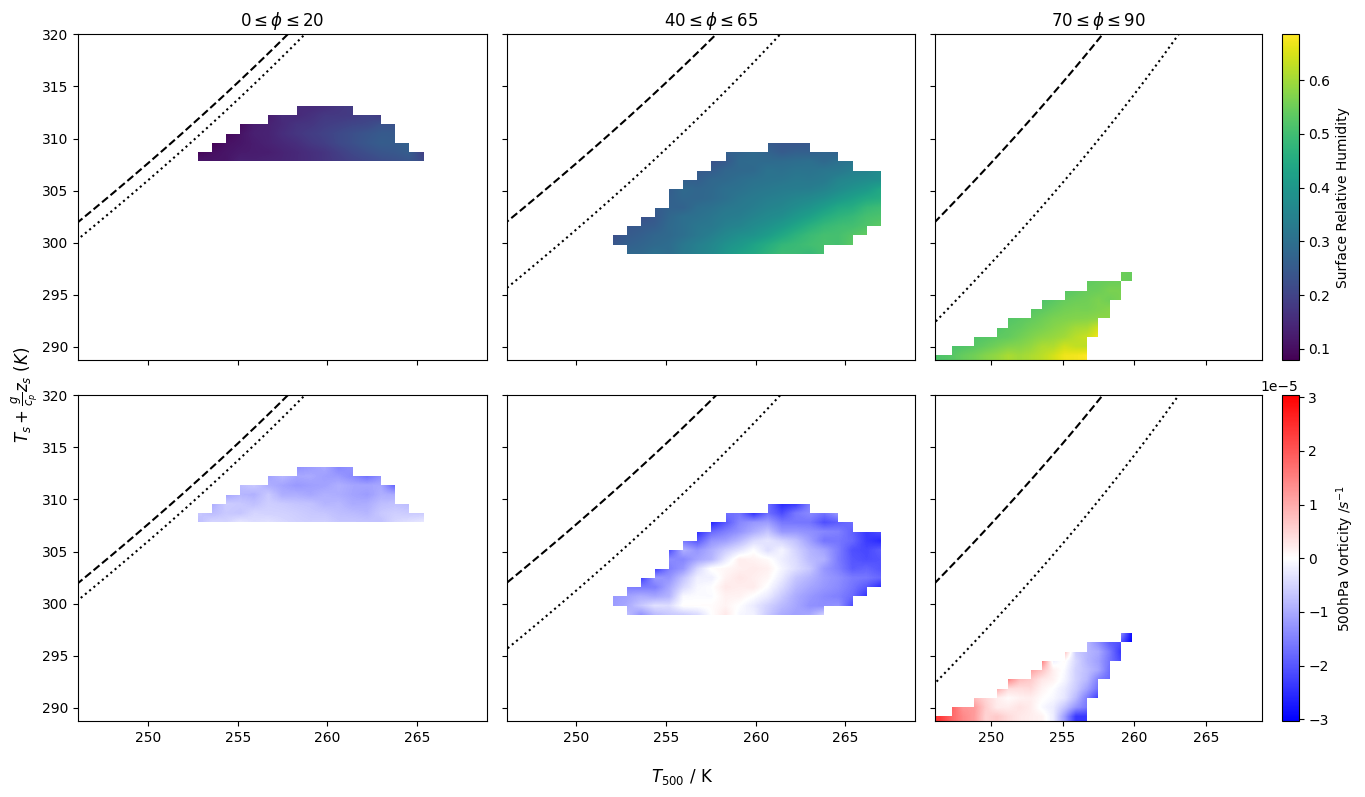

In [17]:
plot_extent = [np.mean(temp_ft_hist_array[:2]), np.mean(temp_ft_hist_array[-2:]),
               np.mean(temp_surf_hist_array[:2]), np.mean(temp_surf_hist_array[-2:])]
rh_lims = [np.nanmin(rh_running_mean), np.nanmax(rh_running_mean)]
vorticity_lims = np.nanmax(np.abs(vorticity_running_mean))
vorticity_lims = [-vorticity_lims, vorticity_lims]
fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
for i in range(n_lat):
    im_rh = ax[0, i].imshow(rh_running_mean[i].T, extent=plot_extent, origin='lower', interpolation='bilinear',
                            vmin=rh_lims[0], vmax=rh_lims[1], aspect='auto')
    im_vort = ax[1, i].imshow(vorticity_running_mean[i].T, extent=plot_extent, origin='lower', interpolation='bilinear',
                              vmin=vorticity_lims[0], vmax=vorticity_lims[1], aspect='auto', cmap='bwr')
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for k in range(2):
        # Plot upper bound and upper bound taking account of min surface sphum
        ax[k, i].plot(temp_ft_array, temp_upper_bound, color='k', linestyle='--')
        ax[k, i].plot(temp_ft_array, temp_upper_bound - float(L_v/c_p * ds_lat[i].sphum[:, -1].min()), color='k', linestyle=':')
fig.supxlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
fig.supylabel('$T_s + \\frac{g}{c_p}z_s$ ($K$)')
ax[0, 0].set_xlim(plot_extent[0],
                  plot_extent[1])
ax[0, 0].set_ylim(plot_extent[2], 320)
plt.colorbar(im_rh, ax=ax[0, -1], label='Surface Relative Humidity')
plt.colorbar(im_vort, ax=ax[1, -1], label=f'{pressure_ft}hPa Vorticity /'+'$s^{-1}$')
plt.tight_layout();

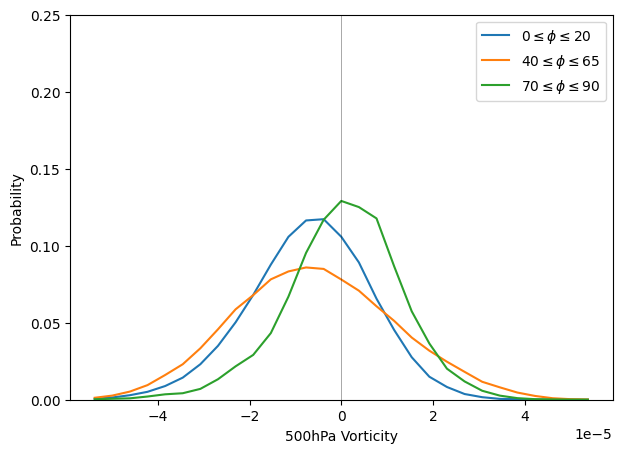

In [18]:
vorticity_max = 0.8 * np.max([np.abs(vorticity_lat[i]).max() for i in range(n_lat)])        # so vorticity on same scale on all plots
vorticity_bins = np.linspace(-vorticity_max,vorticity_max,30)
fig, ax = plt.subplots(1,1, figsize=(7,5), sharex=True)
for i in range(n_lat):
    hist = np.histogram((vorticity_lat[i]* np.sign(vorticity_lat[i].lat)).to_numpy().flatten(),
                        bins=vorticity_bins)
    ax.plot(np.convolve(vorticity_bins, np.ones(2)/2, mode='valid'), hist[0]/np.sum(hist[0]),
            label=f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
ax.vlines(0, 0.25, 0, color='k', alpha=0.6, linewidth=0.4)
ax.set_ylim(0, 0.25)
ax.legend()
ax.set_xlabel(f'{pressure_ft}hPa Vorticity')
ax.set_ylabel('Probability');

In all three regions, the gap between the scatter plot and the dotted line increases as $T_{500}$ does. This is because at each $T_{500}$ value, the minimum surface relative humidity is about the same but because the temperature increases, the saturation specific humidity increases and thus the surface specific humidity also does. So as $T_{500}$ increases, $q - q_{s, min}$ increases.

### High Latitudes, $70 \leq \phi \leq 90$
From the first plot, it seems that there is a strong trend for the 500hPa temperature to increase with surface relative humidity. This is in contrast to what we expect from Zhang 2023. But for a fixed 500hPa temperature, we see a trend for surface temperature to increase as surface relative humidity decreases, which is what we expect.

The second plot shows that there is a trend for the 500hPa temperature to increase as vorticity decreases i.e. becomes more anticyclonic. This matches what we expect from Zhang 2023.

This is the region that best matches the results in the paper, even though in the paper the mid latitude region is used. Maybe it is because this region includes the widest range of relative humidities.

### Midlatitudes, $40 \leq \phi \leq 65$
The second plot shows that the hottest days are associated with anticyclonic behaviour but the trend with $T_{500}$ is less obvious than at high latitudes.

For fixed $T_{500}$, there seems to be a slight trend for increasing surface temperature as relative humidity decreases, but again not as strong as at high latitudes.

### Tropics, $0 \leq \phi \leq 20$
The vorticity plot doesn't show any recognisable trend.
At the largest $T_{500}$, there seems to be a trend for surface temperature to increase as relative humidity decreases.

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [27]:
# Get info to compute surface and free troposphere saturated MSE on hottest day for each year considered
# Keep all pressure values hence use ds[0] not ds_use so can plot a time vs pressure heatmap of variables
# Do separately for each hemisphere as should be indentical
n_years = int(len(ds_use.time)/360)         # multiply by 2 as each hemisphere is identical so get max from each
n_days = 10
n_year_days = 360       # number of days in a year
max_info = {'temp': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'sphum': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'height': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'precipitation': np.zeros((n_lat, n_years, 2, 2*n_days+1)),
            'cape': np.zeros((n_lat, n_years, 2, 2*n_days+1)),
            'cin': np.zeros((n_lat, n_years, 2, 2*n_days+1))}
with tqdm(total= n_lat * n_years * 2, position=0, leave=True) as pbar:
    ds_use_max = ds[0].sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
    for i in range(n_lat):
        for k in range(2):
            if k == 0:
                # NH first
                ds_max0 = ds_use_max.where((ds_use_max.lat<=lat_max[i]) & (ds_use_max.lat>=lat_min[i]), drop=True)
            else:
                # SH second
                ds_max0 = ds_use_max.where((ds_use_max.lat<=-lat_min[i]) & (ds_use_max.lat>=-lat_max[i]), drop=True)
            for j in range(n_years):
                # Consider each year in turn
                ds_max = ds_max0.sel(time=slice(ds_use.time[j*n_year_days], ds_use.time[(j+1)*n_year_days-1])).load()
                max_ind = ds_max.temp[:, -1].argmax(dim=('time', 'lon', 'lat'))
                max_ind = {key: int(max_ind[key]) for key in max_ind}
                ds_max = ds_max0.sel(time=slice(ds_max.time[max_ind['time']]-n_days, ds_max.time[max_ind['time']]+n_days))
                ds_max = ds_max.sel(lon=ds_max.lon[max_ind['lon']], lat=ds_max.lat[max_ind['lat']])
                max_info['temp'][i, j, k] = ds_max.temp
                max_info['sphum'][i, j, k] = ds_max.sphum
                max_info['height'][i, j, k] = ds_max.height
                max_info['precipitation'][i, j, k] = ds_max.precipitation
                max_info['cape'][i, j, k] = ds_max.cape
                max_info['cin'][i, j, k] = ds_max.cin
                pbar.update(1)
ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

100%|██████████| 30/30 [01:50<00:00,  3.68s/it]


In [28]:
max_mse = moist_static_energy(max_info['temp'][:, :, :, :, -1], max_info['sphum'][:, :, :, :, -1], max_info['height'][:, :, :, :, -1])
max_mse_ft = moist_static_energy(max_info['temp'][:, :, :, :, ft_ind],
                                 sphum_sat(max_info['temp'][:, :, :, :, ft_ind], pressure_ft_actual*100),
                                 max_info['height'][:, :, :, :, ft_ind])

# get anomaly of each variable to plot compared to the hottest day
# i.e. hottest day for all of these variables will have a value of 0
max_var_anomaly = [var - np.expand_dims(var[:, :, :, n_days], 3) for var in
                   [max_info['temp'], max_info['cape'], max_info['precipitation'], max_mse, max_mse_ft,
                    max_info['height']]]
max_var_anomaly[4] = max_mse_ft - np.expand_dims(max_mse[:, :, :, n_days], 3)       # make ft mse anomaly relative to max surface mse

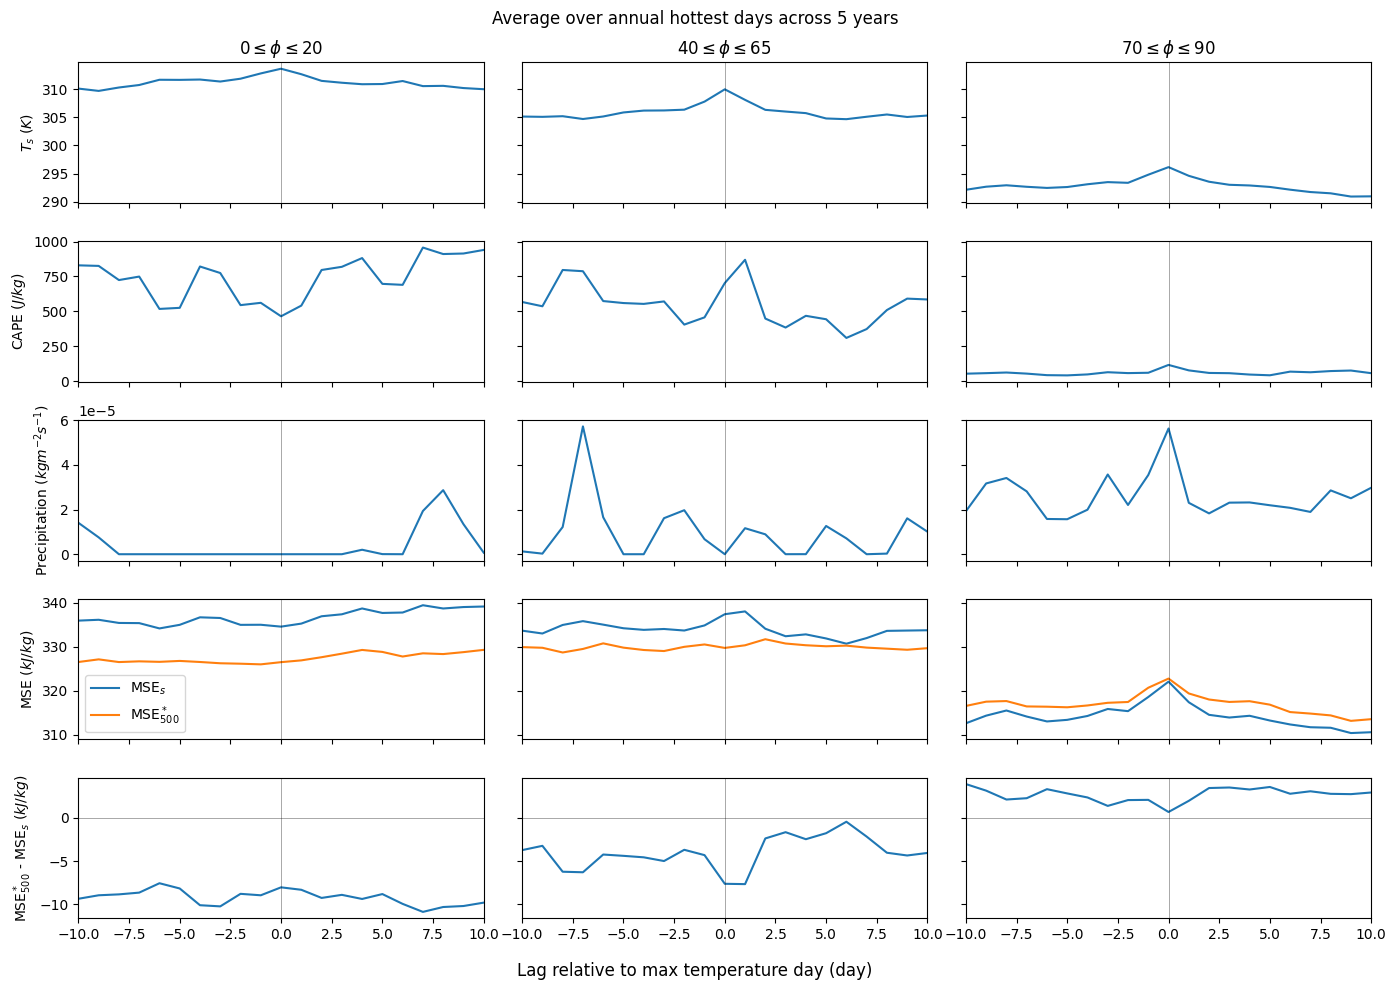

In [29]:
fig, ax = plt.subplots(5, n_lat, figsize=(14,10), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_info['temp'][i, :, :, :, -1], axis=(0,1)))
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_info['cape'][i, :, :, :], axis=(0,1)))
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_info['precipitation'][i, :, :, :], axis=(0,1)))
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse, axis=(1,2))[i], label='MSE$_s$')
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft, axis=(1,2))[i],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
    ax[4, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft-max_mse, axis=(1,2))[i])
    ax[4, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_ylabel('$T_s$ ($K$)')
ax[1, 0].set_ylabel('CAPE ($J/kg$)')
ax[2, 0].set_ylabel('Precipitation ($kgm^{-2}s^{-1}$)')
ax[3, 0].set_ylabel('MSE ($kJ/kg$)')
ax[3, 0].legend()
ax[4, 0].set_ylabel(f"MSE$^*_{'{'+str(pressure_ft)+'}'}$ - MSE$_s$ ($kJ/kg$)")
ax[0, 0].set_xlim(-n_days, n_days)
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years')
plt.tight_layout();

The plot below is the same as that above but before averaging we subtract the value on the hottest day for each year. This way it removes the influence of a particularly anomalous year from the averaging. For the MSE plot, we subtract the surface, $MSE_s$, value on the hottest day from both $MSE_s$ and $MSE^*_{500}$.

So, in the top 3 plots, the y variable of the blue line is always 0 when the x variable is 0. The fourth plot remains the same as in the above plot.

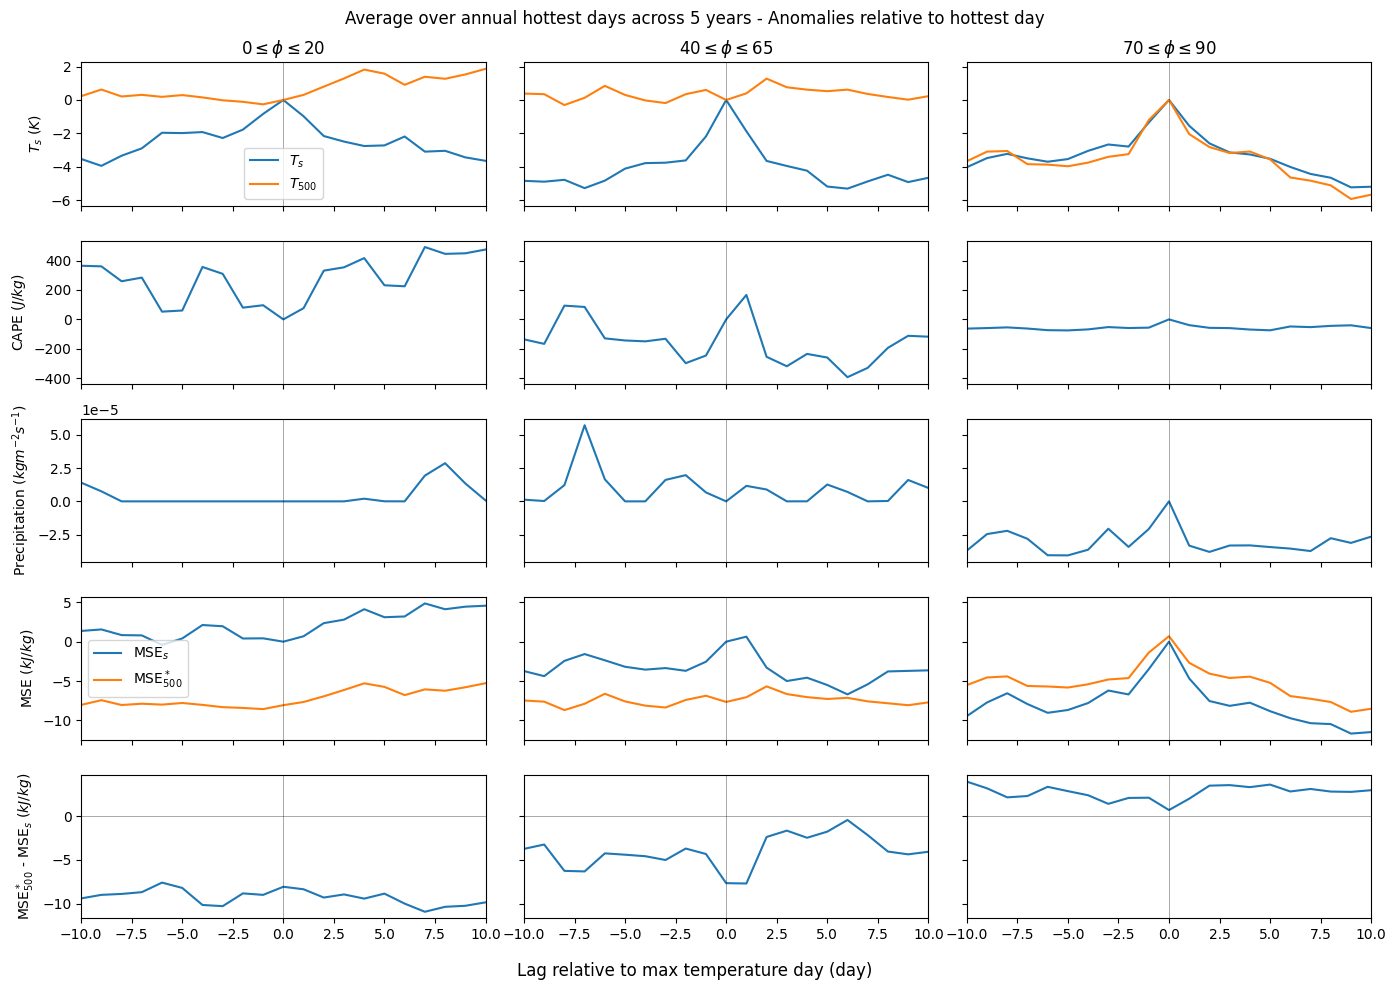

In [30]:
# Repeat above plots but with anomalies
fig, ax = plt.subplots(5, n_lat, figsize=(14,10), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[0][i, :, :, :, -1], axis=(0,1)), label="$T_s$")
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[0][i, :, :, :, ft_ind], axis=(0,1)),
                  label=f"$T_{'{'+str(pressure_ft)+'}'}$")
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[1][i, :, :, :], axis=(0,1)))
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[2][i, :, :, :], axis=(0,1)))
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[3], axis=(1,2))[i], label='MSE$_s$')
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[4], axis=(1,2))[i],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
    ax[4, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[4]-max_var_anomaly[3], axis=(1,2))[i])
    ax[4, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')

for i, ax_use in enumerate(ax.flatten()):
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_ylabel('$T_s$ ($K$)')
ax[1, 0].set_ylabel('CAPE ($J/kg$)')
ax[2, 0].set_ylabel('Precipitation ($kgm^{-2}s^{-1}$)')
ax[3, 0].set_ylabel('MSE ($kJ/kg$)')
ax[0, 0].legend()
ax[3, 0].legend()
ax[4, 0].set_ylabel(f"MSE$^*_{'{'+str(pressure_ft)+'}'}$ - MSE$_s$ ($kJ/kg$)")
ax[0, 0].set_xlim(-n_days, n_days)
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years - Anomalies relative to hottest day')
plt.tight_layout();

The paper only considers the mid-latitudes (middle row here), and it is expected that the $MSE_{500}^*$ should exceed $MSE_s$ both before and after the hottest day, and they should be equal on the hottest day. The idea being that the surface temperature can only rise as long as the atmosphere remains convectively stable, when $MSE_s$ exceeds $MSE_{500}^*$ it is no longer stable and surface temperature and thus $MSE_s$ must decrease.

We see this trend for the high latitudes (third column) here but not for the other regions.

From the paper, we also expect the precipitation to increase after the hottest day, a trend which we see for the tropics but not for the other regions here. However, in Isca, it is the averaged over quite a large grid so may not be that useful to compare to the more localised value in the paper.

### MSE Contributions
Below I see how temperature, relative humidity and geopotential height changes combine to give the time series for moist static energy about the warmest days.

In [31]:
def clausius_clapeyron_factor2(temp, p_level):
    # p_level is pressure level considering in Pa
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65)**2
    return lambda_const * p_level / epsilon * sphum_sat(temp, p_level) / saturation_vapor_pressure(temp)

rh_surf = np.zeros((n_lat, n_years, 2, 2*n_days+1))      # in %
for i in range(n_lat):
    for j in range(n_years):
        for j2 in range(2):
            for k in range(2*n_days+1):
                rh_surf[i, j, j2, k] = 100 * max_info['sphum'][i, j, j2, k, -1] / sphum_sat(
                    max_info['temp'][i, j, j2, k, -1], pressure_surface*100)

mse_diff_cont = {'temp': np.zeros((n_lat, n_years, 2, 2*n_days+1, 2)),
                 'temp_squared': np.zeros((n_lat, n_years, 2, 2*n_days+1, 2)),
                 'rh': np.zeros((n_lat, n_years, 2, 2*n_days+1)),
                 'non-linear': np.zeros((n_lat, n_years, 2, 2*n_days+1)),
                 'height': np.zeros((n_lat, n_years, 2, 2*n_days+1, 2))}
for i, p_level in enumerate([pressure_ft_actual*100, pressure_surface*100]):
    if i == 1:
        q_sat = sphum_sat(max_info['temp'][:, :, :, n_days, -1], p_level)
        prefactor = L_v * q_sat
        rh_diff = (rh_surf - np.expand_dims(rh_surf[:, :, :, n_days], 3))/100
        mse_diff_cont['rh'] =  np.expand_dims(prefactor, 3) * rh_diff
        rh_use = rh_surf[:, :, :, n_days]/100
        temp_diff = max_var_anomaly[0][:, :, :, :, -1]
        height_diff = max_var_anomaly[5][:, :, :, :, -1]
        temp_use = max_info['temp'][:, :, :, n_days, -1]
    else:
        q_sat = sphum_sat(max_info['temp'][:, :, :, n_days, ft_ind], p_level)
        rh_use = 1      # free troposphere is saturated
        temp_diff = max_var_anomaly[0][:, :, :, :, ft_ind]
        height_diff = max_var_anomaly[5][:, :, :, :, ft_ind]
        temp_use = max_info['temp'][:, :, :, n_days, ft_ind]
    alpha_use = clausius_clapeyron_factor2(max_info['temp'][:, :, :, n_days, i], p_level)
    prefactor = (c_p + L_v * alpha_use * q_sat * rh_use)
    mse_diff_cont['temp'][:, :, :, :, i] =  np.expand_dims(prefactor, 3) * temp_diff
    mse_diff_cont['height'][:, :, :, :, i] = g * height_diff
    if i == 1:
        prefactor = prefactor/rh_use
        mse_diff_cont['non-linear'] = np.expand_dims(prefactor, 3) * temp_diff * rh_diff
    prefactor = L_v * rh_use * q_sat * alpha_use * (alpha_use - 2/temp_use)
    mse_diff_cont['temp_squared'][:, :, :, :, i] =  np.expand_dims(prefactor, 3) * temp_diff**2

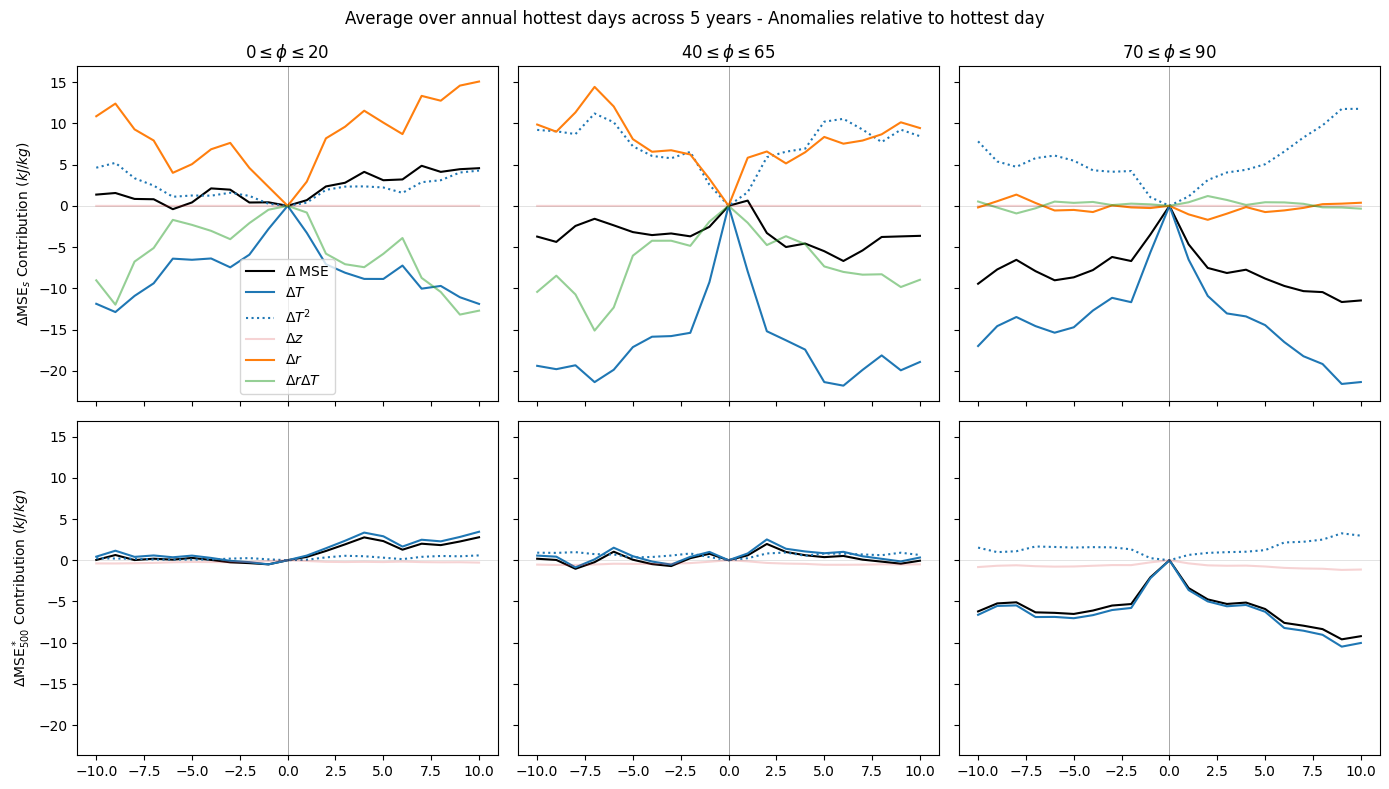

In [32]:
# Break down MSE changes into temperature, relative humidity and geopotential height changes
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2, n_lat, figsize=(14,8), sharex=True, sharey=True)
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[3], axis=(1,2))[i], label='$\Delta$ MSE', color='k')
    ax[1, i].plot(np.arange(-n_days, n_days+1),
                  np.mean(max_var_anomaly[4]- np.expand_dims(max_var_anomaly[4][:, :, :, n_days], 3), axis=(1,2))[i],
                  color='k')
    for j in range(2):
        ax[j, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_diff_cont['temp'][i, :, :, :, 1-j], axis=(0,1))/1000, color=default_colors[0], label='$\Delta T$')
        ax[j, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_diff_cont['temp_squared'][i, :, :, :, 1-j], axis=(0,1))/1000,
                      color=default_colors[0], linestyle=':', label='$\Delta T^2$')
        ax[j, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_diff_cont['height'][i, :, :, :, 1-j], axis=(0,1))/1000,
          color=default_colors[3], alpha=0.2, label='$\Delta z$')
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_diff_cont['rh'][i, :, :, :], axis=(0,1))/1000,
              color=default_colors[1], label='$\Delta r$')
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_diff_cont['non-linear'][i, :, :, :], axis=(0,1))/1000,
                  color=default_colors[2], alpha=0.5, label='$\Delta r \Delta T$')
    # ax[4, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')

for i, ax_use in enumerate(ax.flatten()):
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.hlines(0, -n_days-1, n_days+1, color='k', alpha=0.2, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].legend()
ax[0, 0].set_xlim(-n_days-1, n_days+1)
ax[0, 0].set_ylabel(f"$\Delta$MSE$_s$ Contribution ($kJ/kg$)")
ax[1, 0].set_ylabel(f"$\Delta$MSE$^*_{'{'+str(pressure_ft)+'}'}$ Contribution ($kJ/kg$)")
fig.suptitle(f'Average over annual hottest days across {n_years} years - Anomalies relative to hottest day')
plt.tight_layout();

From these plots, we see that relative humidity, $\Delta r$ is only important on the days after the hottest day in the tropics. Geopotential height, $\Delta z$, is never important.

In the tropics, the free troposphere temperature after the hottest day remains constant because the surface temperature decreases meaning the starting temperature of a rising air parcel is lower. However, the surface relative humidity increases, meaning the LCL moves to a lower altitude (see below) as the parcel has to rise less to reach saturation. Thus, it spends less time on the dry adiabat (high lapse rate) and more time on the moist adiabat (low lapse rate), meaning the temperature difference between the surface and free troposphere decreases.

### LCL
This looks at how the LCL level varies in the period before and after the hottest day.

I use two definitions, one is that labelled by *Isca* which is the actual definition of LCL, i.e. the pressure level where a parcel following the dry adiabat from the surface becomes saturated, so its relative humidity equals 100%.

The one labelled $T_{dry}-T$ is determined by the pressure level at which the temperature profile deviates from the dry adiabat by the threshold amount indicated. LCL is really a misnomer for this, but for a convectively neutral profile, you would expect the two LCLs be broadly the same with the temperature profile following the dry adiabat below it and the moist adiabat above it.

In [54]:
# Compute lcl pressure and a version of lcl by eye where temp profile deviates from dry adiabat by > 1K
def lcl_pressure_isca(temp_surf, pressure_surf, sphum_surf):
    """
    Returns LCL pressure in Pa.

    Args:
        temp_surf:
        pressure_surf: In Pa.
        sphum_surf:
    """
    temp_lcl = lcl_temp(temp_surf, pressure_surf, sphum_surf)
    return pressure_surf * (temp_lcl/temp_surf)**(1/kappa)

def lcl_pressure_by_eye(temp, pressure, temp_thresh = -1):
    """
    Returns LCL pressure in Pa.

    Args:
        temp: [-1] is surface
        pressure: In Pa, [-1] is surface
        temp_thresh: LCL is defined where temp deviates from dry adiabat by this amount
    """
    temp_prof_dev = dry_profile(temp[-1], pressure[-1], pressure) - temp
    return interpolate.InterpolatedUnivariateSpline(pressure, temp_prof_dev - temp_thresh).roots()[-1] # take level closest to surface

lcl_temp_thresh = -0.7
rh_surf = np.zeros((n_lat, n_years, 2, 2*n_days+1))      # in %
p_lcl_isca = np.zeros((n_lat, n_years, 2, 2*n_days+1))      # in hPa
p_lcl_eye = np.zeros((n_lat, n_years, 2, 2*n_days+1))       # in hPa
for i in range(n_lat):
    for j in range(n_years):
        for j2 in range(2):
            for k in range(2*n_days+1):
                rh_surf[i, j, j2, k] = 100 * max_info['sphum'][i, j, j2, k, -1] / sphum_sat(
                    max_info['temp'][i, j, j2, k, -1], pressure_surface*100)
                # Isca output LCL
                p_lcl_isca[i, j, j2, k] = lcl_pressure_isca(max_info['temp'][i, j, j2, k, -1], pressure_surface*100,
                                                            max_info['sphum'][i, j, j2, k, -1])/100
                # By eye LCL
                p_lcl_eye[i, j, j2, k] = lcl_pressure_by_eye(max_info['temp'][i, j, j2, k], ds[0].pfull*100, lcl_temp_thresh)/100
max_lcl_anomaly = [var - np.expand_dims(var[:, :, :, n_days], 3) for var in [p_lcl_isca, p_lcl_eye]]

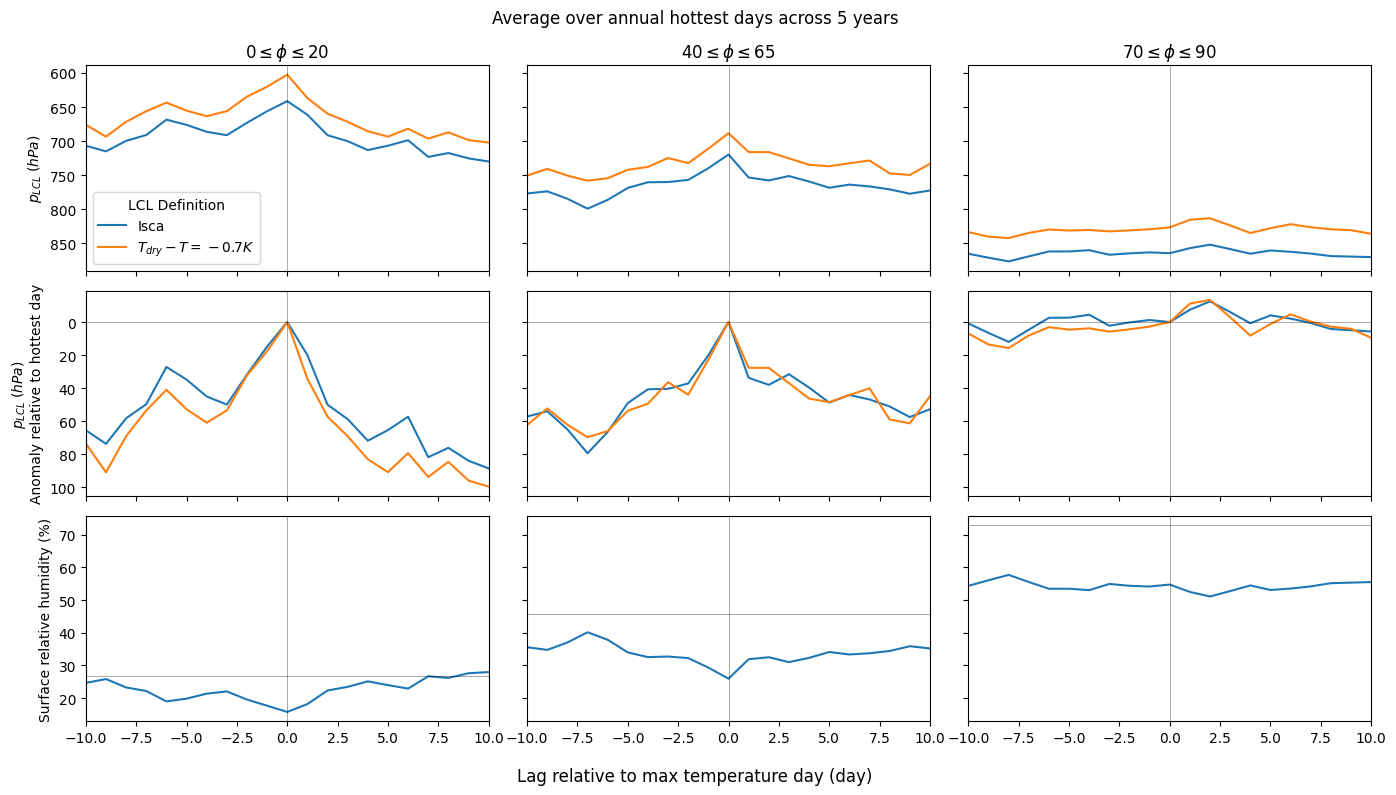

In [55]:
fig, ax = plt.subplots(3, n_lat, figsize=(14,8), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(p_lcl_isca[i], axis=(0,1)), label='Isca')
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(p_lcl_eye[i], axis=(0,1)),
                  label='$T_{dry} - T='+f'{lcl_temp_thresh} K$')
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_lcl_anomaly[0][i], axis=(0,1)), label='Isca')
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_lcl_anomaly[1][i], axis=(0,1)),
                  label='$T_{dry} - T='+f'{lcl_temp_thresh} K$')
    ax[1, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(rh_surf[i], axis=(0,1)))
    ax[2, i].hlines(rh_surf_mean[i], -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].invert_yaxis()
ax[1, 0].invert_yaxis()
ax[0, 0].set_xlim(-n_days, n_days)
ax[0, 0].legend(title='LCL Definition')
ax[0, 0].set_ylabel('$p_{LCL}$ ($hPa$)')
ax[1, 0].set_ylabel('$p_{LCL}$ ($hPa$)\nAnomaly relative to hottest day')
ax[2, 0].set_ylabel('Surface relative humidity (%)')
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years')
plt.tight_layout();

##### LCL and RH Trend
In the tropics, we see a clear trend for the LCL to move to lower altitudes after the hottest day, independent of the LCL used. This is reflected in an increase in surface relative humidity after the hottest day. The $T_{dry}-T$ LCL shows a sharp increase immediately preceeding the hottest day. This may indicate a physical mechanism i.e. for the hottest days, longer is spent on the dry adiabat, which leads to larger surface temperatures due to the increase in temperature along this profile (dry lapse rate > moist lapse rate).

In the relative humidity plots, we see that in the tropics, the days proceeding the hottest day are anomalously dry compared to the mean (grey horizontal line) but the days after are anomalously moist. In the other two regions, the hottest days are drier than the average, as may be expected.
This increase in relative humidity after the hottest day explains the aysymmetry in the MSE plot in the above figure for the tropics i.e. that surface MSE after the hottest day is greater than that before it, even though the temperature is the same.

In the high latitudes, we see a trend for the $LCL$ to move to lower altitudes on the hottest day.

In all three regions, the $T_{dry}-T$ LCL is at a higher altitude than the *Isca* version, indicating that the temperature profile remains approximately equal to the dry adiabat, even above the LCL. The trend before and after the hottest day only differs between the definitions for the tropics though.

### Figure S2 - Time series of specific heatwave events
This shows the temperature and MSE timeseries for a specific heatwave event in each of the latitude regions. Average temperature for each vertical level over the shown time periods are subtracted to emphasize the anomalies.

It seems that in the tropics and midlatitudes, the free troposphere level is responding to the surface, whereas we would expect it to be the other way around, as is more the case in the high latitudes.

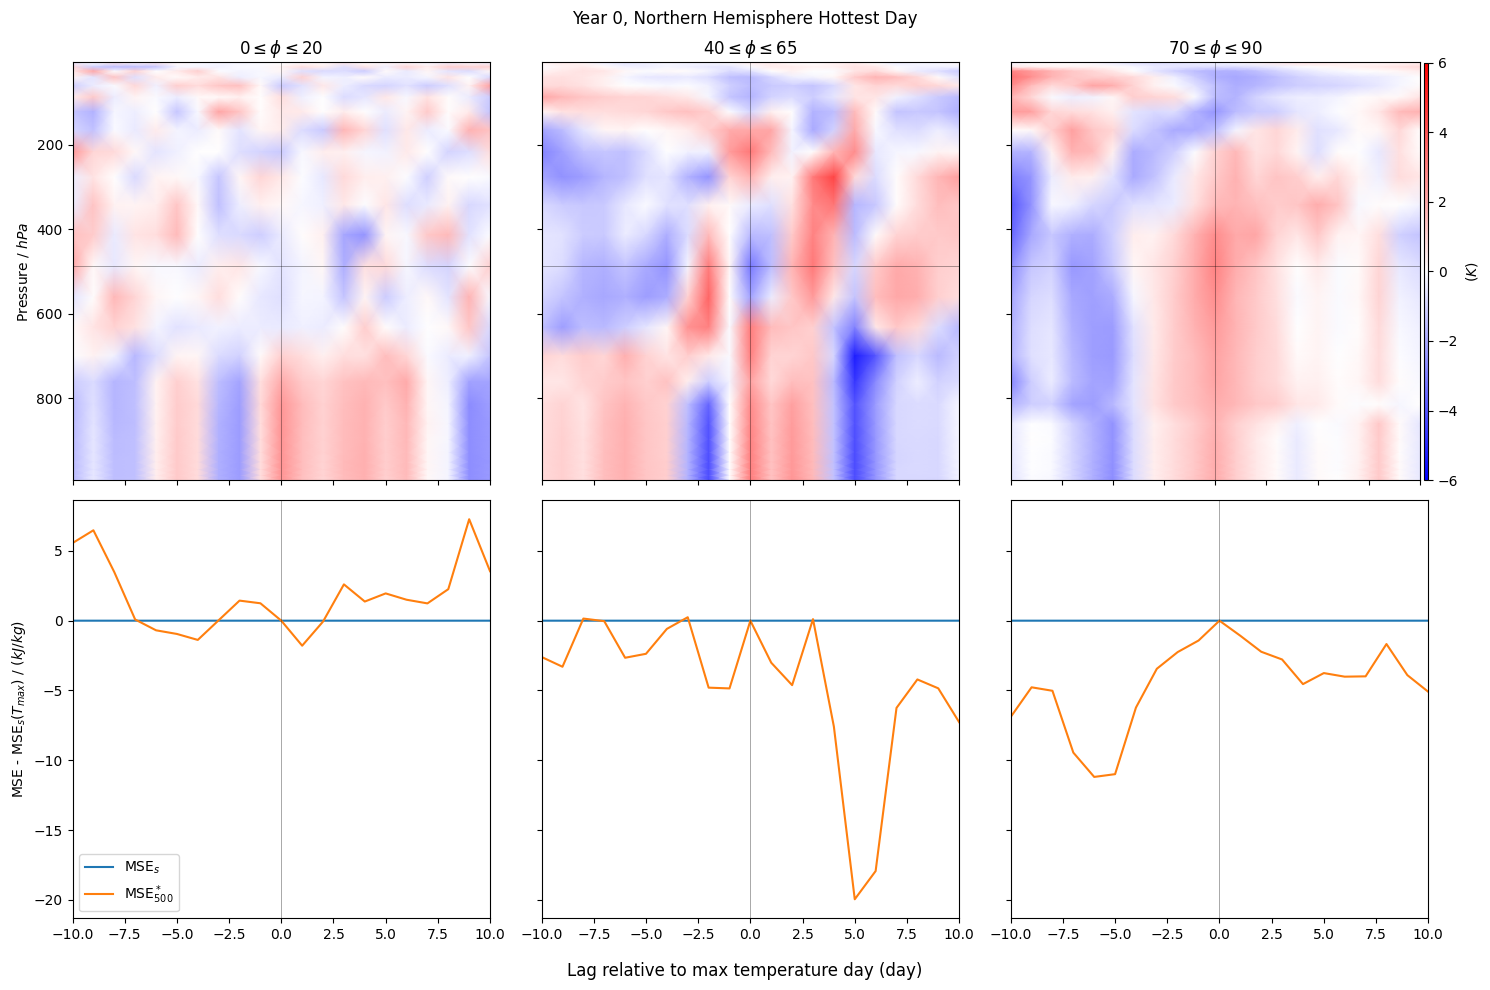

In [56]:
plot_ind = [0, 0]
fig, ax = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey='row')
for i in range(n_lat):
    im_data = max_info['temp'][i, plot_ind[0], plot_ind[1]] - np.mean(max_info['temp'][i, plot_ind[0], plot_ind[1]], axis=0)
    im = ax[0, i].pcolormesh(np.arange(-n_days, n_days+1), ds[0].pfull, im_data.T, cmap='bwr', shading='gouraud', vmin=-6, vmax=6)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    ax[0, i].hlines(pressure_ft_actual, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[1, i].plot(np.arange(-n_days, n_days+1), max_var_anomaly[2][i, plot_ind[0], plot_ind[1], :], label='MSE$_s$')
    ax[1, i].plot(np.arange(-n_days, n_days+1), max_var_anomaly[3][i, plot_ind[0], plot_ind[1], :],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, ax=ax[0, i], label='($K$)', aspect=100, pad=0.01, fraction=0.01)
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylabel('Pressure / $hPa$')
ax[1, 0].set_ylabel('MSE - MSE$_s(T_{max})$ / ($kJ/kg$)')
ax[1, 0].legend()
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day')
plt.tight_layout();

### Figure S6
Below I try to replicate figure S6 in the supplementary material by plotting the temperature profile on days immediately preceeding the hottest day.

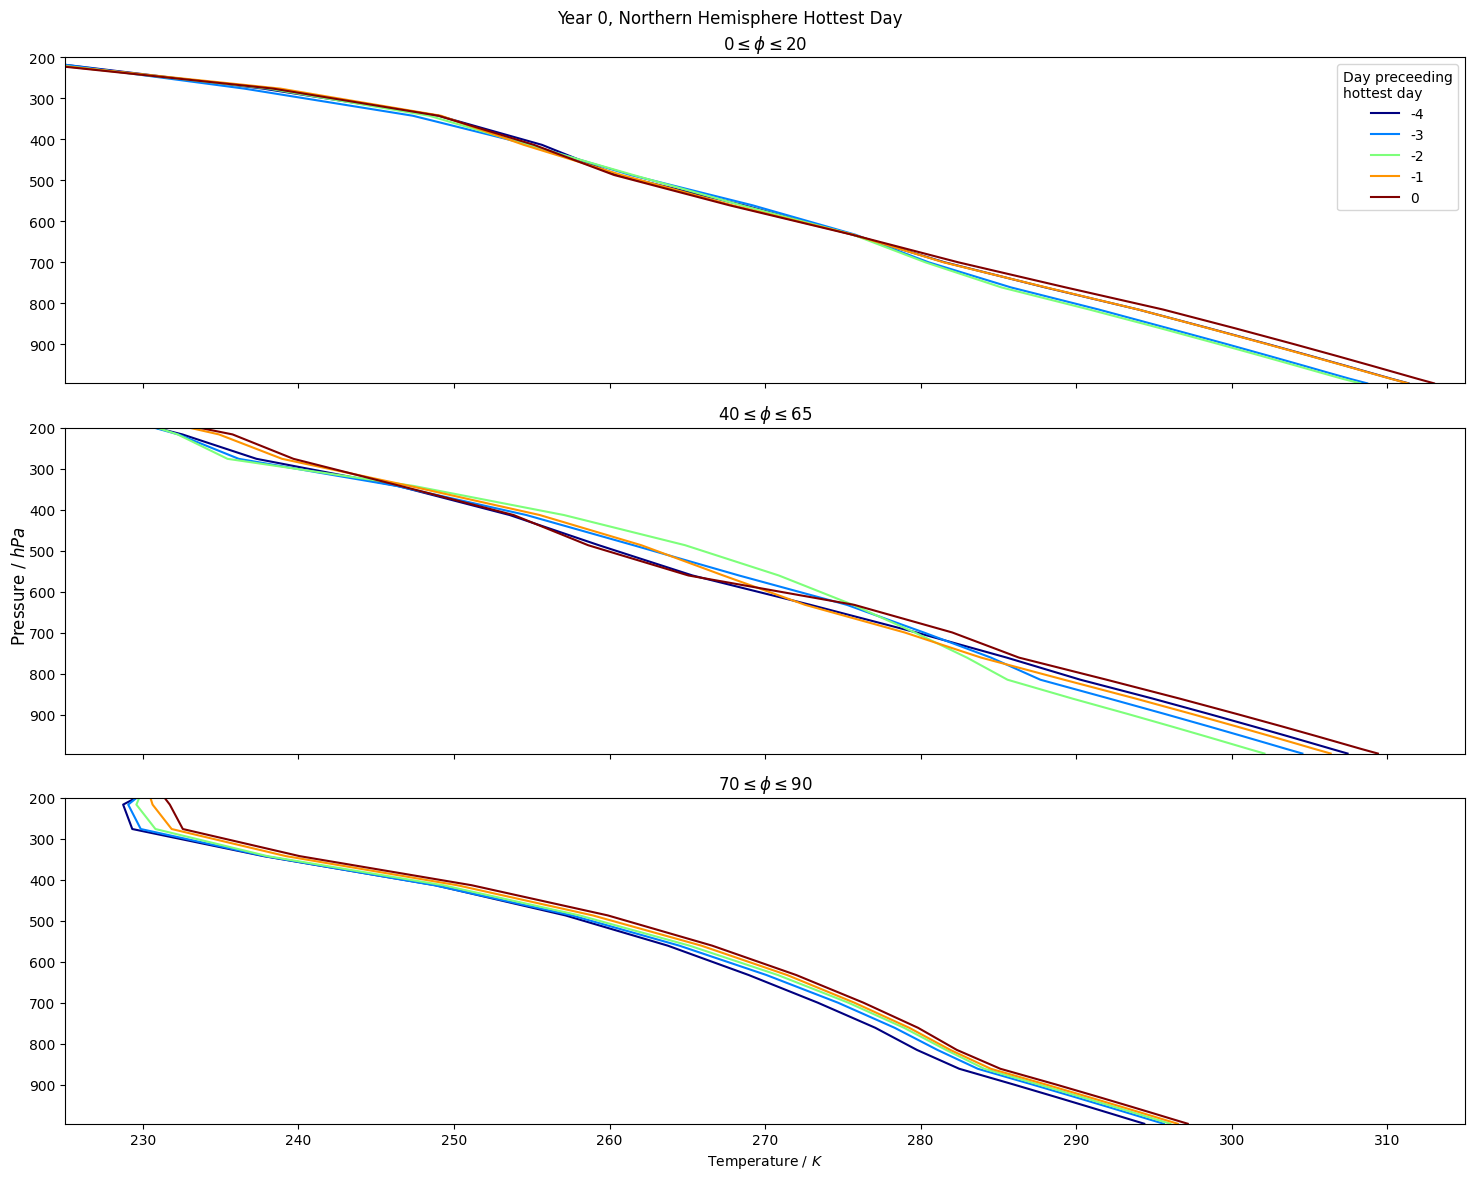

In [111]:
n_days_preceed = 4
warm_colors = plt.cm.jet(np.linspace(0,1,n_days_preceed+1))
fig, ax = plt.subplots(3,1, figsize=(15,12), sharey=True, sharex=True)
for i in range(n_lat):
    ax[i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for j in range(n_days-n_days_preceed, n_days+1):
        ax[i].plot(max_info['temp'][i, plot_ind[0], plot_ind[1]][j], ds[0].pfull, label=f'{j-n_days}',
                   color=warm_colors[j-n_days+n_days_preceed])
ax[0].legend(title='Day preceeding\nhottest day')
ax[0].invert_yaxis()
ax[0].set_ylim(pressure_surface, 200)
ax[0].set_xlim(225, 315)
fig.supylabel('Pressure / $hPa$')
ax[-1].set_xlabel('Temperature / $K$')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day')
plt.tight_layout();

#### Focus on Tropics
In the tropics, it appears that all days follow the same profile in the free troposphere, around 500 hPa, but the hottest day changes to a dry adiabat at higher altitude (lower pressure) than the other days and hence when it reaches the surface, it is hotter. This would make sense if on the hottest day, the relative humidity was less, so it has to reach higher altitudes to get saturated - spends more time on the dry adiabat.

However, from the plot below, we see that the pressure of the LCL does not change much on the hottest day from the days preceeding it.

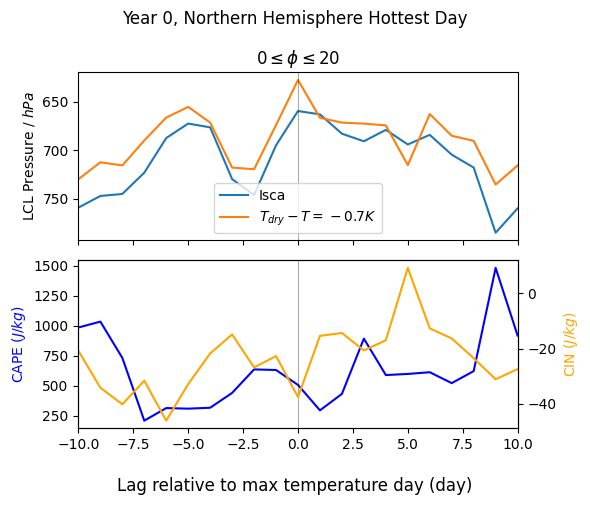

In [101]:
trop_ind = 0
fig, ax = plt.subplots(2,1, figsize=(6,5), sharex=True)

ax[0].plot(np.arange(-n_days, n_days+1), p_lcl_isca[trop_ind, plot_ind[0], plot_ind[1]], label='Isca')
ax[0].plot(np.arange(-n_days, n_days+1), p_lcl_eye[trop_ind, plot_ind[0], plot_ind[1]], label='$T_{dry} - T='+f'{lcl_temp_thresh} K$')
ax[1].plot(np.arange(-n_days, n_days+1), max_info['cape'][trop_ind, plot_ind[0], plot_ind[1]], color='blue')
ax[1].set_ylabel('CAPE ($J/kg$)', color='blue')
ax2 = ax[1].twinx()
ax2.plot(np.arange(-n_days, n_days+1), max_info['cin'][trop_ind, plot_ind[0], plot_ind[1]], color='orange')
ax2.set_ylabel('CIN ($J/kg$)', color='orange')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0].set_xlim(-n_days, n_days)
ax[0].invert_yaxis()
ax[0].legend()
ax[0].set_ylabel('LCL Pressure / $hPa$')
ax[0].set_title(f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day')
plt.tight_layout();

But clearly, the LCL level indicated in the above plot does not match the transition from dry to moist adiabat as shown below. We see that there is an altitude range between the green and yellow lines, which is close to the dry adiabat. Then above the yellow line, we see that the temperature profile closely follows the moist adiabat.

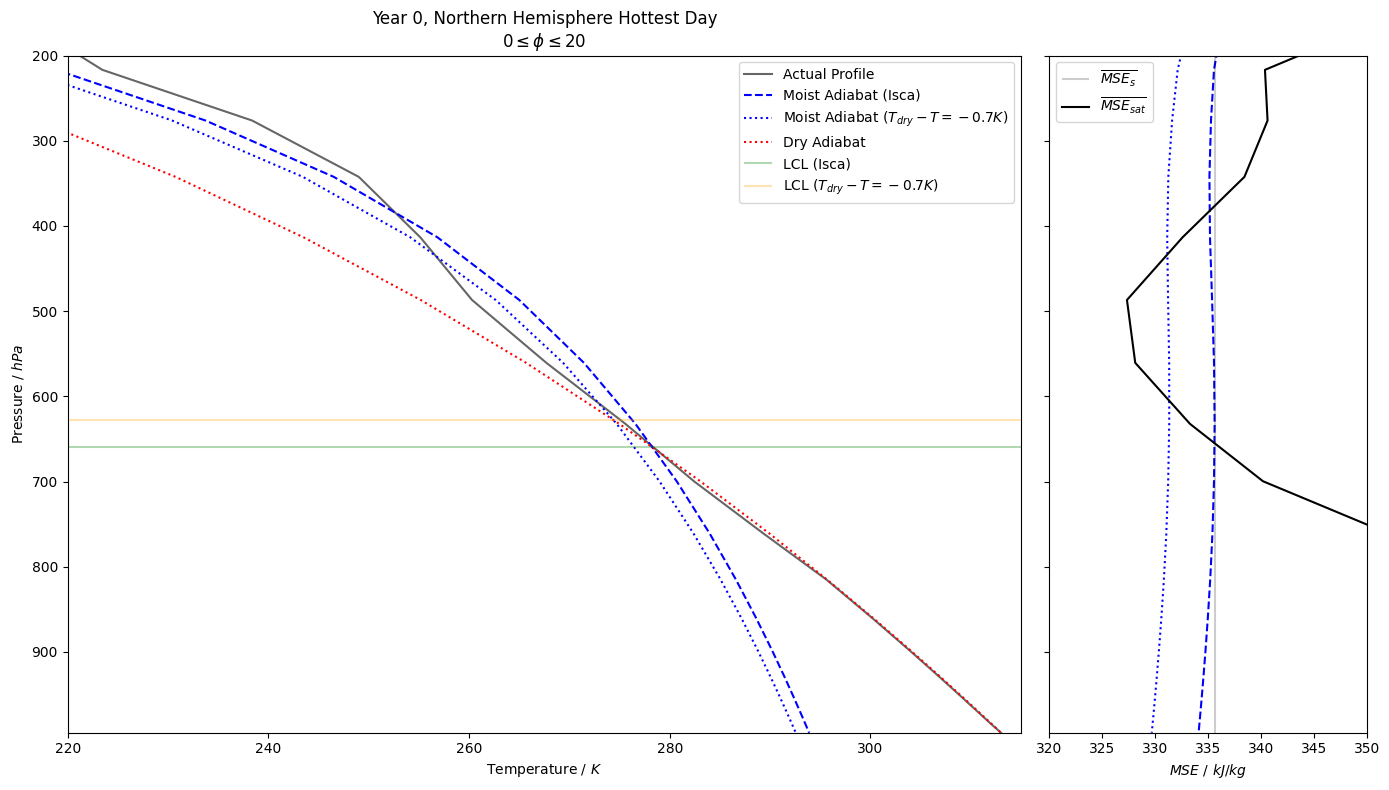

In [102]:
# Plot temperature profile for a single day
def get_temp_lcl(p_lcl, p_surf, temp_surf):
    return temp_surf * (p_lcl/p_surf)**kappa

day_plot = n_days
adiabat_labels = ['Moist Adiabat (Isca)', 'Moist Adiabat ($T_{dry} - T='+f'{lcl_temp_thresh} K$)', 'Dry Adiabat']
adiabat_linestyles = ['--', ':']

adiabat_temp_surf = max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], day_plot, -1]
adiabat_p_lcl = [var[trop_ind, plot_ind[0], plot_ind[1], day_plot] for var in [p_lcl_isca, p_lcl_eye]]
adiabat_temp_lcl = [get_temp_lcl(adiabat_p_lcl[i], pressure_surface, adiabat_temp_surf) for i in range(2)]
adiabat_profiles = [moist_profile(adiabat_temp_lcl[i], adiabat_p_lcl[i] * 100, ds[0].pfull * 100) for i in range(2)]

fig, ax = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
# Plot actual profile
ax[0].plot(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], day_plot], ds[0].pfull, label='Actual Profile', color='k', alpha=0.6)
# Plot adiabats
for i in range(2):
    ax[0].plot(adiabat_profiles[i], ds[0].pfull, color='b', linestyle=adiabat_linestyles[i], label=adiabat_labels[i])
ax[0].plot(dry_profile(adiabat_temp_surf, pressure_surface * 100, ds[0].pfull * 100),
        ds[0].pfull, color='r', linestyle=':', label=adiabat_labels[2])
ax[0].hlines(p_lcl_isca[trop_ind, plot_ind[0], plot_ind[1], day_plot], 200, 320, color='g', alpha=0.3,
             label='LCL (Isca)')
ax[0].hlines(p_lcl_eye[trop_ind, plot_ind[0], plot_ind[1], day_plot], 200, 320, color='orange', alpha=0.3,
             label='LCL ($T_{dry} - T='+f'{lcl_temp_thresh} K$)')
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_ylim(pressure_surface, 200)
ax[0].set_xlim(220, 315)
ax[0].set_ylabel('Pressure / $hPa$')
ax[0].set_xlabel('Temperature / $K$')
if day_plot == n_days:
    day_label = 'Hottest Day'
elif day_plot < n_days:
    day_label = f'{np.abs(day_plot-n_days)} days before Hottest Day'
else:
    day_label = f'{np.abs(day_plot-n_days)} days after Hottest Day'
ax[0].set_title(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + f' {day_label}\n'
                f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')

# Sanity check that warmer adiabat has same MSE as surface
for i in range(2):
    ax[1].plot(moist_static_energy(adiabat_profiles[i], sphum_sat(adiabat_profiles[i], ds[0].pfull * 100),
                                   max_info['height'][trop_ind, plot_ind[0], plot_ind[1], day_plot]), ds[0].pfull,
               color='b', linestyle=adiabat_linestyles[i])
ax[1].vlines(max_mse[trop_ind, plot_ind[0], plot_ind[1], day_plot], 0, 1000, color='k', alpha=0.2, label='$\overline{MSE_s}$')
ax[1].plot(moist_static_energy(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], day_plot],
                    sphum_sat(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], day_plot], ds[0].pfull*100),
                    max_info['height'][trop_ind, plot_ind[0], plot_ind[1], day_plot]), ds[0].pfull,
           color='k', label='$\overline{MSE_{sat}}$')
ax[1].legend()
if trop_ind <= 1:
    ax[1].set_xlim(320, 350)
else:
    ax[1].set_xlim(315, 330)
ax[1].set_xlabel('$MSE$ / $kJ/kg$')
plt.tight_layout();

The plot below is the same as that above but is an average over all of the hottest days.

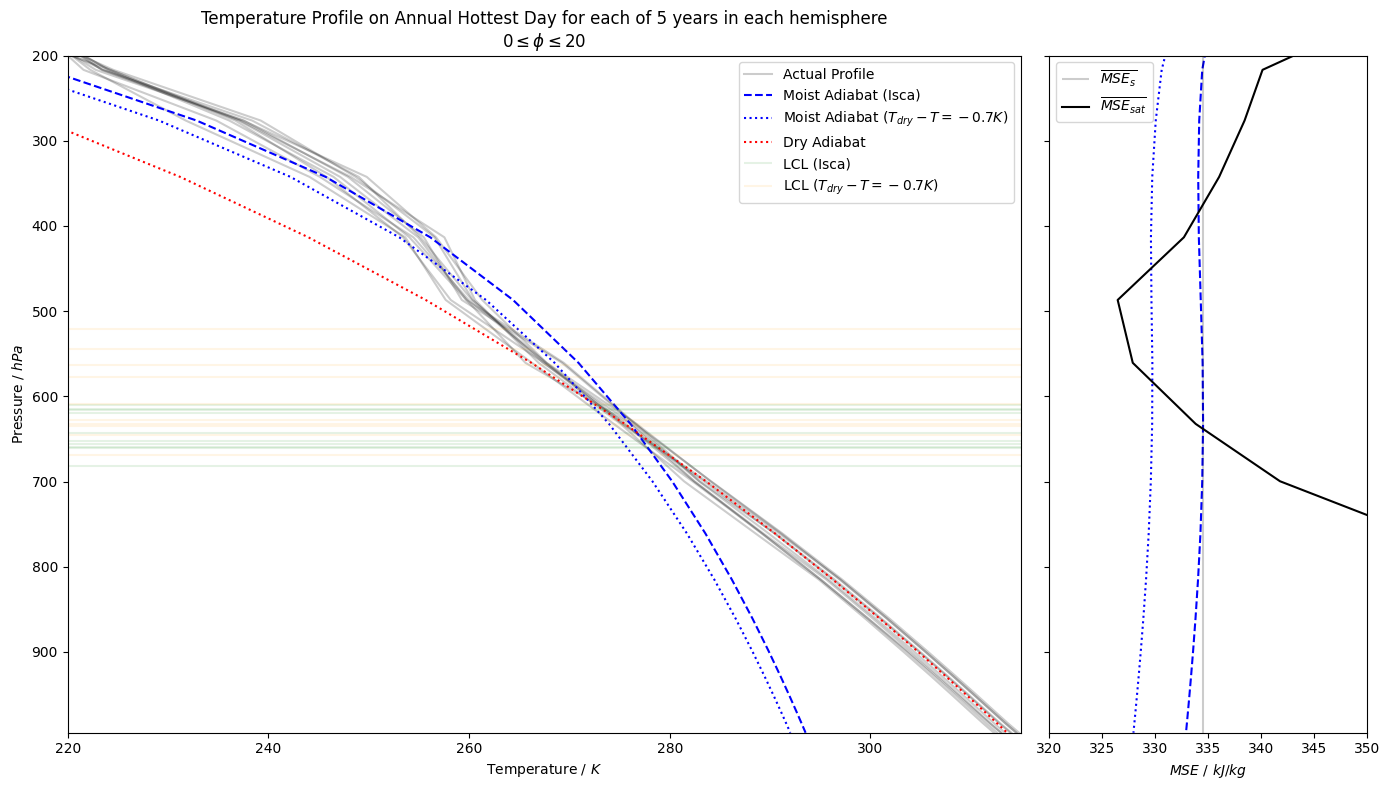

In [103]:
# Plot temperature profile averaged over all hottest days
adiabat_temp_surf = np.mean(max_info['temp'][trop_ind, :, :, n_days, -1])
# temperature so match convectively neutral profile

# Compute lcl from the mean surface temp than from the average of each LCL individually
adiabat_p_lcl = np.zeros(2)
adiabat_p_lcl[0] = lcl_pressure_isca(adiabat_temp_surf, pressure_surface*100,
                                     np.mean(max_info['sphum'][trop_ind, :, :, n_days, -1]))/100
adiabat_p_lcl[1] = lcl_pressure_by_eye(np.mean(max_info['temp'][trop_ind, :, :, n_days], axis=(0,1)), ds[0].pfull*100,
                                       lcl_temp_thresh)/100
# adiabat_p_lcl = [lcl_pressure_by_eye(np.mean(max_info['temp'][trop_ind, :, :, n_days], axis=(0,1)), ds[0].pfull*100)/100
#                  for var in [p_lcl_isca, p_lcl_eye]]
adiabat_temp_lcl = [get_temp_lcl(adiabat_p_lcl[i], pressure_surface, adiabat_temp_surf) for i in range(2)]
adiabat_profiles = [moist_profile(adiabat_temp_lcl[i], adiabat_p_lcl[i] * 100, ds[0].pfull * 100) for i in range(2)]

fig, ax = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
for i in range(max_info['temp'].shape[1]):
    for j in range(max_info['temp'].shape[2]):
        if i + j == 0:
            label = 'Actual Profile'
        else:
            label = None
        ax[0].plot(max_info['temp'][trop_ind, i, j][n_days], ds[0].pfull, label=label,
                color='k', alpha=0.2)
for i in range(2):
    ax[0].plot(adiabat_profiles[i], ds[0].pfull, color='b', linestyle=adiabat_linestyles[i], label=adiabat_labels[i])
ax[0].plot(dry_profile(adiabat_temp_surf, pressure_surface * 100, ds[0].pfull * 100),
        ds[0].pfull, color='r', linestyle=':', label=adiabat_labels[2])
# for temp_500 in range(245, 285, 10):
#     ax.plot(moist_profile(temp_500, pressure_ft_actual * 100, ds[0].pfull * 100),
#             ds[0].pfull, color='b', linestyle=':', label=adiabat_labels[0])
#     ax.plot(dry_profile(temp_500+2, pressure_ft_actual * 100, ds[0].pfull * 100),
#         ds[0].pfull, color='r', linestyle=':', label=adiabat_labels[1])
#     adiabat_labels = [None, None]
ax[0].hlines(p_lcl_isca[trop_ind, :, :, n_days].flatten(), 200, 320, color='g', alpha=0.1, label='LCL (Isca)')
ax[0].hlines(p_lcl_eye[trop_ind, :, :, n_days].flatten(), 200, 320, color='orange', alpha=0.1, label='LCL ($T_{dry} - T='+f'{lcl_temp_thresh} K$)')
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_ylim(pressure_surface, 200)
ax[0].set_xlim(220, 315)
ax[0].set_ylabel('Pressure / $hPa$')
ax[0].set_xlabel('Temperature / $K$')
ax[0].set_title(f'Temperature Profile on Annual Hottest Day for each of {n_years} years in each hemisphere\n'
                f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')

# Sanity check that warmer adiabat has same MSE as surface
for i in range(2):
    ax[1].plot(moist_static_energy(adiabat_profiles[i], sphum_sat(adiabat_profiles[i], ds[0].pfull * 100),
                                   np.mean(max_info['height'][trop_ind, :, :, n_days], axis=(0,1))), ds[0].pfull,
               color='b', linestyle=adiabat_linestyles[i])
ax[1].vlines(np.mean(max_mse[trop_ind, :, :, n_days], axis=(0,1)), 0, 1000, color='k', alpha=0.2, label='$\overline{MSE_s}$')
ax[1].plot(moist_static_energy(np.mean(max_info['temp'][trop_ind, :, :, n_days], axis=(0, 1)),
                    sphum_sat(np.mean(max_info['temp'][trop_ind, :, :, n_days], axis=(0, 1)), ds[0].pfull*100),
                    np.mean(max_info['height'][trop_ind, :, :, n_days], axis=(0, 1))), ds[0].pfull,
           color='k', label='$\overline{MSE_{sat}}$')
ax[1].legend()
if trop_ind <= 1:
    ax[1].set_xlim(320, 350)
else:
    ax[1].set_xlim(315, 330)
ax[1].set_xlabel('$MSE$ / $kJ/kg$')
plt.tight_layout();

The temperature profile for these hottest days seem to follow the dry adiabat from the surface up to where it intersects the lower moist adiabat at about 800hPa. Then there is a little bit of CAPE where the blue dotted line is warmer than the black lines between around 780hPa and 700hPa. At pressures lower than this, the environmental profile is warmer than the moist adiabat and so at 500hPa we have the free troposphere saturated MSE (as given by black line) being greater than the surface MSE (as given by the blue dotted line).

However, the LCL computed by Isca is given by the green line. A parcel following the dry adiabat up to this pressure and then following the higher moist adiabat would have surface MSE greater than the free troposphere saturated MSE at 500hPa.

So maybe, rather than using entrainment, we can explain why in Isca the surface MSE is greater than the free troposphere saturated MSE by using this difference between expected LCL and actual LCL.

The plot on the right is just a sanity check that the LCL calculation is correct i.e. that the surface MSE matches the free troposphere saturated MSE on the *Isca* moist adiabat. This is indeed the case as the blue dashed line matches up well to the grey line. The grey line is the average surface moist static energy over all grey lines in the left plot.
The fact that the black solid line is approximately equal to the blue dotted line for most of the free troposphere, implies that the hottest day in the tropics is convectively neutral, as long as we use this new formulation of the LCL level, rather than that given by Isca.

Below, we show the *bye eye* LCL before and after the hottest day. This is defined by the pressure where $T_{dry} - T = -0.7K$, where $T_{dry}$ is the dry adiabat temperature. Clearly, the temporal evolution of this definition of LCL is more in keeping with what we expect i.e. the hottest day spends longest on dry adiabat so has LCL at highest altitude.

#### Lapse Rate Deviation
The plot below shows the lapse rate deviation for a specific heatwave event in the days proceeding and after the hottest day. On the days proceeding it, it very closely follows the dry adiabat up to the LCL. On the days after it, it starts deviating from the dry adiabat basically from the surface.

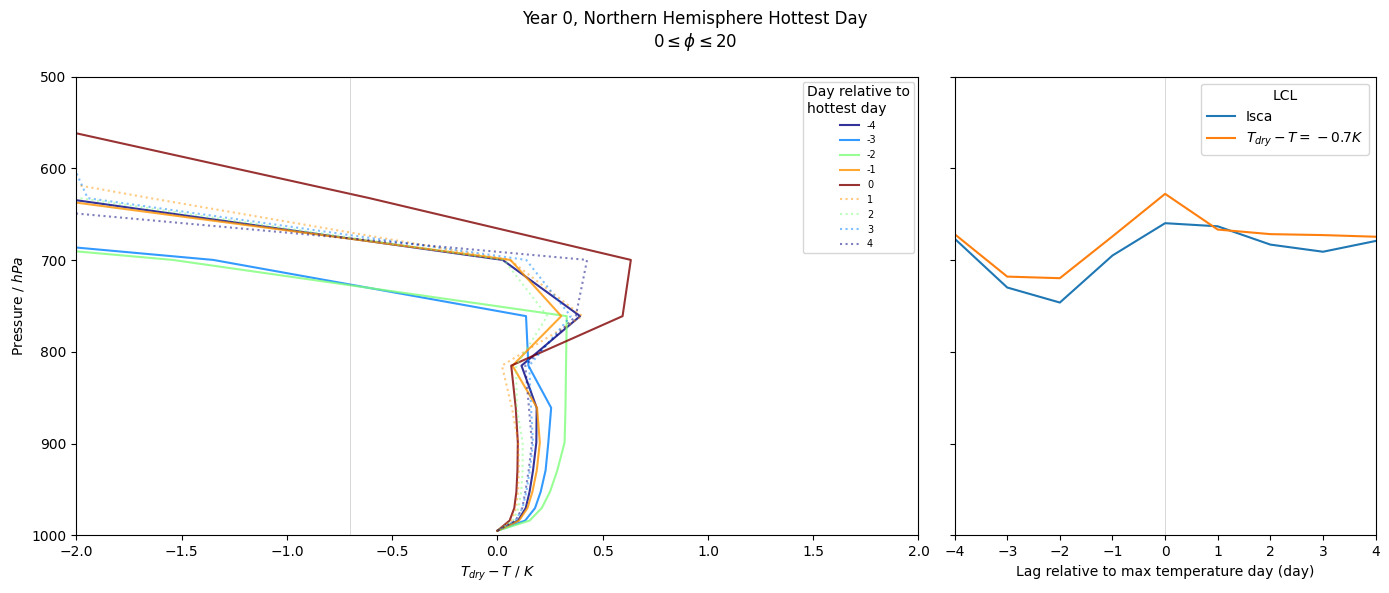

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
for j in range(n_days-n_days_preceed, n_days+1):

    temp_prof_dev = dry_profile(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][j][-1], pressure_surface*100, ds[0].pfull*100) \
                    -max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][j]
    ax[0].plot(temp_prof_dev, ds[0].pfull,
             color=warm_colors[j-n_days+n_days_preceed], alpha=0.8, label=f'{j-n_days}')
for j in range(n_days+1, n_days+n_days_preceed+1):
    temp_prof_dev = dry_profile(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][j][-1], pressure_surface*100, ds[0].pfull*100)\
                    -max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][j]
    ax[0].plot(temp_prof_dev, ds[0].pfull,
             color=warm_colors[-(j-n_days+1)], linestyle=':', alpha=0.5, label=f'{j-n_days}')

ax[0].vlines(lcl_temp_thresh, 1000, 500, color='grey', alpha=0.3, linewidth=0.7)
ax[1].vlines(0, 1000, 500, color='grey', alpha=0.3, linewidth=0.7)
ax[1].plot(np.arange(-n_days_preceed, n_days_preceed+1),
           p_lcl_isca[trop_ind, plot_ind[0], plot_ind[1]][n_days-n_days_preceed: n_days+n_days_preceed+1], label='Isca')
ax[1].plot(np.arange(-n_days_preceed, n_days_preceed+1),
           p_lcl_eye[trop_ind, plot_ind[0], plot_ind[1]][n_days-n_days_preceed: n_days+n_days_preceed+1],
           label='$T_{dry} - T='+f'{lcl_temp_thresh} K$')
ax[0].invert_yaxis()
ax[0].legend(title='Day relative to\nhottest day', fontsize=7)
ax[1].legend(title='LCL')
ax[0].set_xlim(-2,2)
ax[0].set_ylim(1000, 500)
ax[0].set_ylabel('Pressure / $hPa$')
ax[1].set_xlim(-n_days_preceed,n_days_preceed)
ax[1].set_xlabel('Lag relative to max temperature day (day)')
ax[0].set_xlabel('$T_{dry} - T$ / $K$')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day\n'+
             f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')
plt.tight_layout();

### MSE with different LCL
The MSE computed at the surface is equal to the saturated MSE along the moist adiabat that intersects the Isca LCL as shown in the right plot of the temperature profile figure above. Below we see how the MSE trend before and after the hottest day compares if we instead assume the surface MSE is equal to the saturated MSE along the moist adiabat that intersects the $T_{dry}-T$ LCL.

Using this different $MSE_s$ in orange, we see that on the days proceeding the hottest day, the surface MSE is less than the free troposphere saturated MSE (black), as we may expect from the mechanism in zhang 2023. But on the days after it, we see a spike in surface MSE, above the free troposphere value, and it remains slightly above it after the spike.

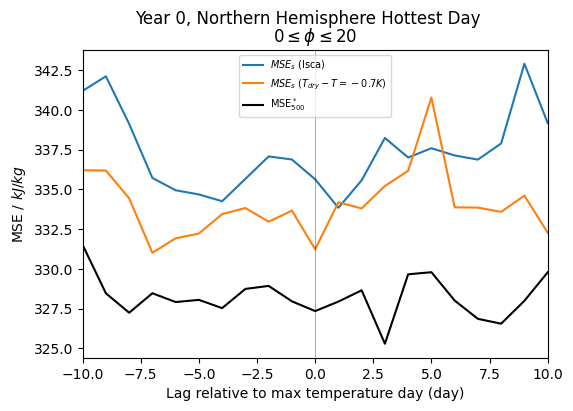

In [105]:
def get_mse_surf_by_eye(p_lcl, temp_surf, pressure_surf, pressure_free_trop, height_ft):
    """
    Returns MSE in kJ/kg
    Args:
        p_lcl: In Pa
        temp_surf:
        pressure_surf: In Pa
        pressure_free_trop: In Pa
        height_ft:
    """
    temp_lcl = get_temp_lcl(p_lcl, pressure_surf, temp_surf)
    temp_ft = moist_profile(temp_lcl, p_lcl, pressure_free_trop)
    return moist_static_energy(temp_ft, sphum_sat(temp_ft, pressure_free_trop), height_ft)

mse_surf_eye_single = [float(get_mse_surf_by_eye(p_lcl_eye[trop_ind, plot_ind[0], plot_ind[1], i]*100,
                              max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], i, -1], pressure_surface*100,
                              np.asarray([pressure_ft_actual])*100,
                              max_info['height'][trop_ind, plot_ind[0], plot_ind[1], i, ft_ind]))
             for i in range(2*n_days+1)]
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(-n_days, n_days+1), max_mse[trop_ind, plot_ind[0], plot_ind[1]], label='$MSE_s$ (Isca)')
ax.plot(np.arange(-n_days, n_days+1), mse_surf_eye_single, label='$MSE_s$ ($T_{dry} - T='+f'{lcl_temp_thresh} K$)')
ax.plot(np.arange(-n_days, n_days+1), moist_static_energy(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], :, ft_ind],
                             sphum_sat(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], :, ft_ind], pressure_ft_actual*100),
                             max_info['height'][trop_ind, plot_ind[0], plot_ind[1], :, ft_ind]),
         label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$", color='k')

for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax.set_xlim(-n_days, n_days)
ax.legend(fontsize=7)
ax.set_ylabel('MSE / $kJ/kg$')
ax.set_title(f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')
ax.set_xlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day');

The figure below is the same as that above but averaged over all the hottest days for each of the three latitude regions. The results for the tropics are broadly the same as mentioned above.

In the midlatitudes and polar regions, we see the orange line is always below the black line, indicating that convective neutrality is never quite reached. We also see a spike in the orange line on the hottest day for these regions.

In [106]:
mse_surf_eye = np.zeros((n_lat, n_years, 2, 2*n_days+1))
for i in range(n_lat):
    for j in range(n_years):
        for j2 in range(2):
            for k in range(2*n_days+1):
                mse_surf_eye[i, j, j2, k] = get_mse_surf_by_eye(p_lcl_eye[i, j, j2, k]*100,
                                                                max_info['temp'][i, j, j2, k, -1], pressure_surface*100,
                                                                np.asarray([pressure_ft_actual])*100,
                                                                max_info['height'][i, j, j2, k, ft_ind])

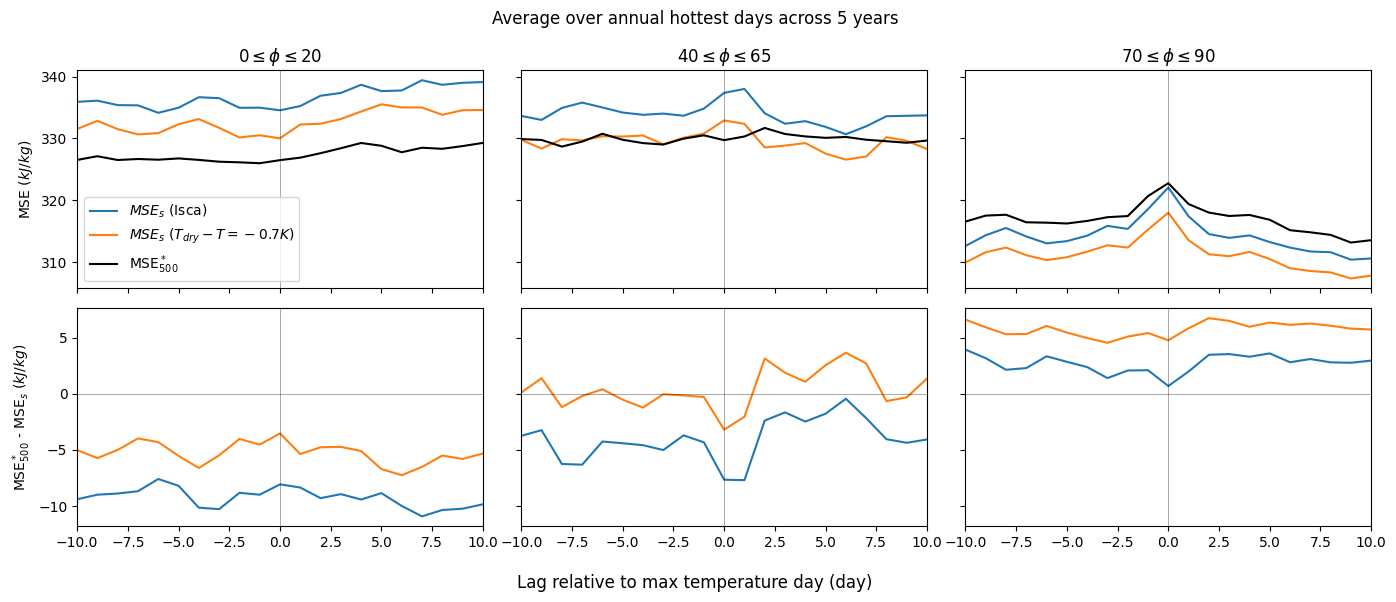

In [107]:
fig, ax = plt.subplots(2, n_lat, figsize=(14,6), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse, axis=(1,2))[i], label='$MSE_s$ (Isca)')
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(mse_surf_eye, axis=(1,2))[i],
                  label='$MSE_s$ ($T_{dry} - T='+f'{lcl_temp_thresh} K$)')
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft, axis=(1,2))[i],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$", color='k')
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft-max_mse, axis=(1,2))[i], label='$MSE_s$ (Isca)')
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft-mse_surf_eye, axis=(1,2))[i],
                  label='$MSE_s$ ($T_{dry} - T='+f'{lcl_temp_thresh} K$)')
    ax[1, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')

for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_xlim(-n_days, n_days)
ax[0, 0].set_ylabel('MSE ($kJ/kg$)')
ax[0, 0].legend()
ax[1, 0].set_ylabel(f"MSE$^*_{'{'+str(pressure_ft)+'}'}$ - MSE$_s$ ($kJ/kg$)")
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years')
plt.tight_layout();

Bit of a play with computing the *By Eye* LCL with the deviation of the lapse rate by 15% rather than by the deviation of the temperature itself.

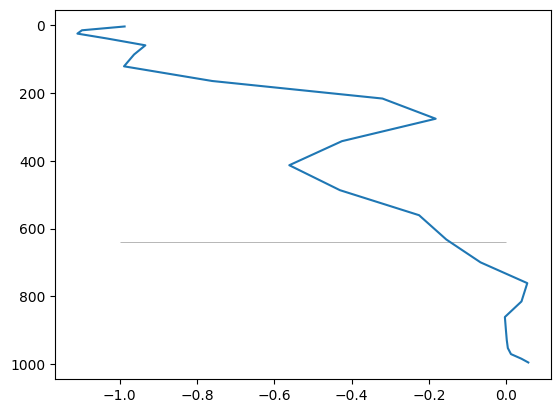

In [108]:
lapse_dev = (-np.gradient(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1], day_plot],
            max_info['height'][trop_ind, plot_ind[0], plot_ind[1], day_plot]) - g/c_p)/(g/c_p)
plt.hlines(interpolate.InterpolatedUnivariateSpline(ds[0].pfull, lapse_dev + 0.15).roots()[-1], -1, 0, color='grey', linewidth=0.4)
plt.plot(lapse_dev, ds[0].pfull)
plt.gca().invert_yaxis()